In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os.path

## Variables Pannel

In [2]:
mask_name = "E1M33R" #Input mask name

## Get Excluded and Includes Slit Numbers

In [3]:
def get_exclusions():
    filepath = 'ISM_EM_LINES.txt'
    fp = open(filepath)
    all_data = []
    for line in (fp):
        mask_name = line.split(':')[0].split('_')[0]
        slit_number = line.split(':')[1].strip().split(" ")[0]
        if len(slit_number) == 2:
            slit_number = '0' + slit_number
        elif len(slit_number) == 1:
            slit_number = '00' + slit_number
        else:
            pass
        object_id = line.split(':')[1].strip().split()[1]
        data = {}
        data['mask_name'] = mask_name
        data['slit_number'] = slit_number
        data['object_id'] = object_id
        all_data.append(data)
    return all_data     

In [4]:
def get_files_to_include(folder):
    import os
    list_of_files_to_include = []
    list_of_files_to_exclude = []
    serendip_files = []
    all_file_names_in_folder = os.listdir('data/{}'.format(folder))
    y = len(all_file_names_in_folder)
    print("The number of files in the folder is {0}".format(y))
    all_data = get_exclusions()
    len_all_data = len(all_data)
    for n in range(y):
        parts_of_file_name = all_file_names_in_folder[n].split(".")
        if parts_of_file_name[0] == 'spec1d': # avoids hidden DS_Store files on my mac
            object_id = parts_of_file_name[3]
            slit_number = parts_of_file_name[2]
            mask_name = parts_of_file_name[1]
            should_include = True
            should_exclude = True
            for k in range(len_all_data):
                if ((object_id == all_data[k]['object_id']) and (slit_number == all_data[k]['slit_number']) and (mask_name == all_data[k]['mask_name'])):
                    should_include = False
                    should_exclude = True
                if 'serendip' in object_id:
                    should_include = False
                    should_exclude = False
            if should_include == True:
                list_of_files_to_include.append(all_file_names_in_folder[n])       
            elif should_exclude == True:
                list_of_files_to_exclude.append(all_file_names_in_folder[n])
            elif should_include == False & should_exclude == False:
                serendip_files.append(all_file_names_in_folder[n])
    
    print('The number of files left after exclusions is {0}'.format(len(list_of_files_to_include)))
    
    return sorted(list_of_files_to_include), sorted(list_of_files_to_exclude), sorted(serendip_files)


In [5]:
def get_slit_nums(files):
    
    slit_nums = []
    
    if len(files) > 1:
    
        for i in range(len(files)):
            parts_of_file_name = files[i].split(".")
            slit_num = parts_of_file_name[2]
            slit_nums.append(int(slit_num))
            
    return slit_nums

In [6]:
#filtering files
list_of_files_to_include, list_of_files_to_exclude, list_of_serendip_files = get_files_to_include(mask_name)

file_names = list_of_files_to_include #included
file_names_exclude = list_of_files_to_exclude #excluded
file_names_serendip = list_of_serendip_files #serendips

The number of files in the folder is 307
The number of files left after exclusions is 130


In [7]:
slit_nums = get_slit_nums(file_names)
slit_nums_exclude = get_slit_nums(file_names_exclude)

print("Slit # to INCLUDE in median calculation: {0}".format(slit_nums))
print("Slit # to EXCLUDE: {0}".format(slit_nums_exclude))
print("Len of EXCL Slits: {0}".format(len(slit_nums_exclude)))

Slit # to INCLUDE in median calculation: [0, 1, 2, 3, 9, 12, 14, 15, 21, 23, 24, 27, 33, 39, 40, 41, 42, 44, 45, 47, 50, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 89, 90, 92, 93, 94, 95, 96, 98, 99, 101, 102, 104, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 117, 118, 119, 121, 122, 123, 125, 126, 128, 129, 131, 133, 135, 136, 138, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 157, 158, 159, 160, 161, 162, 164, 167, 168, 169, 170, 171, 172, 173, 175, 178, 179, 181, 182, 183, 185, 186, 187, 188, 189, 191, 193, 194, 195, 196]
Slit # to EXCLUDE: [4, 5, 6, 7, 8, 10, 11, 13, 16, 17, 18, 19, 20, 25, 26, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 43, 46, 48, 49, 51, 52, 53, 54, 67, 73, 75, 81, 88, 91, 97, 100, 103, 116, 120, 124, 127, 130, 134, 139, 140, 156, 165, 166, 174, 176, 177, 190, 192]
Len of EXCL Slits: 58


## Read RA and DEC

In [8]:
def read_sky_coor(mask_name,list_of_excl_files,slit_nums_exclude):
    
    ra = [] #in deg
    dec = [] #in deg
    
    for file in list_of_excl_files:
        #extracting RA and DEC from data files
        open_fits = fits.open("./data/{0}/{1}".format(mask_name,file))
        ra_obj = open_fits[1].header["RA_OBJ"].split(":") #[Hour,Min,Sec]
        dec_obj = open_fits[1].header["DEC_OBJ"].strip("+").split(":") #[Deg,Min,Sec]
        
        #converting RA (HMS) to degrees format
        ra_obj_deg = (float(ra_obj[0]) + (float(ra_obj[1])/60) + (float(ra_obj[2])/3600)) * 15
        ra.append(ra_obj_deg)
        
        #converting Dec (DMS) to degrees format
        dec_obj_deg = (float(dec_obj[0]) + (float(dec_obj[1])/60) + (float(dec_obj[2])/3600))
        dec.append(dec_obj_deg)
    
    #create DataFrame
    df = pd.DataFrame({"Mask Name":np.full(len(ra),mask_name),"Slit Number":slit_nums_exclude
                       ,"RA":ra,"DEC":dec})
    
    return df

In [9]:
df = read_sky_coor(mask_name,file_names_exclude,slit_nums_exclude)

## Extract Redshift

In [10]:
import numpy
def loadMarzResults(filepath):
    return numpy.genfromtxt(filepath, delimiter=',', skip_header=2, autostrip=True, names=True, dtype=None)

In [11]:
#arrays containing all slits processed in MARZ
res = loadMarzResults("./Marz_Results (Redone)/{0}_Marz_KN.mz".format(mask_name)) 
confident = res[res['QOP'] == 4]

/Users/ngokhang2000/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
redshift = {} #empty dict for redshift value
QOP = {} #empty dict for QOP

for n in range(len(res)): #sorting 
    redshift["Slit_{0}".format(slit_nums_exclude[n])] = res[n][12]*300000 #km/s
    QOP["Slit_{0}".format(slit_nums_exclude[n])] = res[n][13]

df["Redshift"] = redshift.values() #adding column titled "Redshift" into DF
df["QOP"] = QOP.values() #adding column titled "QOP" into DF

## Saving DataFrame as a CSV file

In [13]:
def savingdf_csv(df):
    if os.path.isfile("./Redshift CSV/Redshift.csv") == False: #isfile check if a file exist
        df.to_csv("./Redshift CSV/Redshift.csv",index=False)
    else:
        csv_to_df = pd.read_csv("./Redshift CSV/Redshift.csv")
        new_df = pd.concat([csv_to_df,df]) #concat add two DF together 
        new_df.to_csv("./Redshift CSV/Redshift.csv",index=False) #put index_column = False so that 
        #the overwritten csv file don't have extra column called "unnamed"

In [14]:
savingdf_csv(df)

## Plotting

In [15]:
df1 = pd.read_csv("./Redshift CSV/Redshift.csv")
df1_qop2_sorted = df1["QOP"] >= 2 #use only values that has a QOP of >= 2
df1_qop3_sorted = df1["QOP"] == 3 #use only values that has a QOP of 3

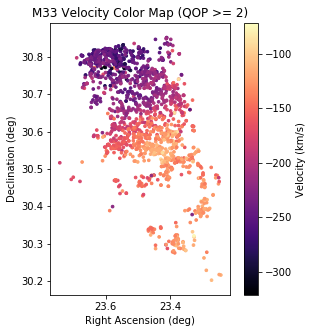

In [16]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("M33 Velocity Color Map (QOP >= 2)")
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(df1["RA"][df1_qop2_sorted]
                    ,df1["DEC"][df1_qop2_sorted]
                    ,c=df1["Redshift"][df1_qop2_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map (QOP >= 2)")

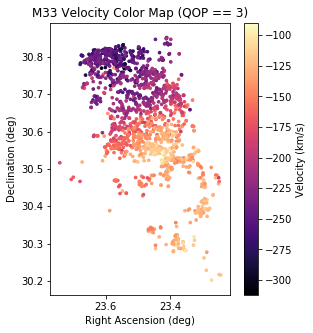

In [17]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("M33 Velocity Color Map (QOP == 3)")
ax.set_aspect(1/0.861)
ax.invert_xaxis()
cc_map = ax.scatter(df1["RA"][df1_qop3_sorted]
                    ,df1["DEC"][df1_qop3_sorted]
                    ,c=df1["Redshift"][df1_qop3_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map")

## Using Delta_RA and Delta_Dec

In [18]:
#ra_m32 = 01:33:50.8966
#dec_m32 = +30:39:36.630
ra_m32 = (1 + (33/60) + (50.8966/3600))*15 #in deg
dec_m32 = (30 + (39/60) + (36.630/3600)) # in deg

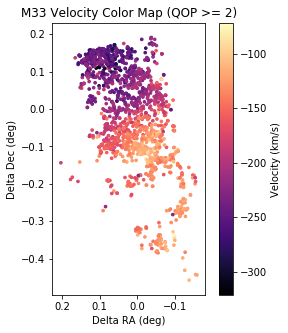

In [19]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Delta RA (deg)")
ax.set_ylabel("Delta Dec (deg)")
ax.set_title("M33 Velocity Color Map (QOP >= 2)")
ax.invert_xaxis()
ax.set_aspect("equal")
cc_map = ax.scatter(((df1["RA"][df1_qop2_sorted]-ra_m32)*np.cos(dec_m32))
                    ,(df1["DEC"][df1_qop2_sorted]-dec_m32)
                    ,c=df1["Redshift"][df1_qop2_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map (QOP >= 2) w Del RA and Dec")

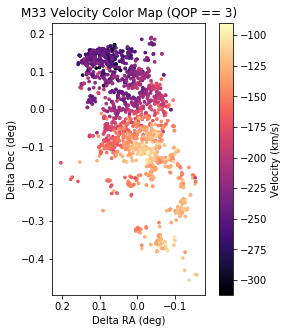

In [20]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Delta RA (deg)")
ax.set_ylabel("Delta Dec (deg)")
ax.set_title("M33 Velocity Color Map (QOP == 3)")
ax.invert_xaxis()
ax.set_aspect("equal")
cc_map = ax.scatter(((df1["RA"][df1_qop3_sorted]-ra_m32)*np.cos(dec_m32))
                    ,(df1["DEC"][df1_qop3_sorted]-dec_m32)
                    ,c=df1["Redshift"][df1_qop3_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map w Del RA and Dec")

## Changes to E1M33R (3/24)

In [ ]:
redshiftCSV = pd.read_csv("Redshift CSV/Redshift.csv")

In [ ]:
E1M33Ridx = redshiftCSV["Mask Name"].isin(["E1M33R"])

In [ ]:
idx = np.where(E1M33Ridx)
print(idx[0])

In [ ]:
redshiftCSV.drop(idx[0],inplace=True)

In [ ]:
redshiftCSV.to_csv("./Redshift CSV/Redshift.csv",index=False)